### Processing the labels of the raw IMDB data

In [1]:
import os

imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenizing the text of the raw IMDB data

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Creating embedding_matrix

In [3]:
glove_dir = './glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### The model

In [4]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras import optimizers
from keras import losses
from keras import metrics

def run_model(x_train, y_train, x_val, y_val, use_pretrain=False, embedding_matrix=None):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    if use_pretrain:
        if embedding_matrix is None:
            raise Exception('embedding_matrix not provided')
        model.layers[0].set_weights([embedding_matrix])
        model.layers[0].trainable = False
        
    model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
    history = model.fit(x_train, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=0)
    return history

### model with pre-trained word-embed

In [11]:
history = run_model(x_train, y_train, x_val, y_val, True, embedding_matrix)

### model without pre-trained word-embed

In [12]:
history2 = run_model(x_train, y_train, x_val, y_val)

### Compare with / without pre-train word embed

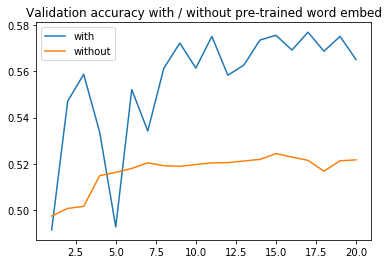

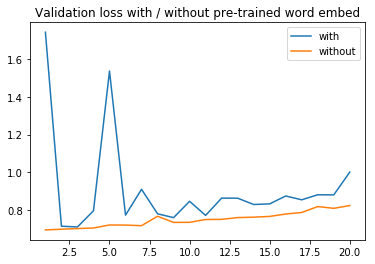

In [13]:
import matplotlib.pyplot as plt

val_acc1 = history.history['val_binary_accuracy']
val_acc2 = history2.history['val_binary_accuracy']
val_loss1 = history.history['val_loss']
val_loss2 = history2.history['val_loss']


epochs = range(1, len(val_acc1) + 1)

plt.plot(epochs, val_acc1, label='with')
plt.plot(epochs, val_acc2, label='without')
plt.title('Validation accuracy with / without pre-trained word embed')
plt.legend()

plt.figure()

plt.plot(epochs, val_loss1, label='with')
plt.plot(epochs, val_loss2, label='without')
plt.title('Validation loss with / without pre-trained word embed')
plt.legend()

plt.show()